In [29]:
# TODO: z_d, z_nucleosynthesis
# TODO: non-gaussian and covariant likelihoods

import numpy as np
import emcee
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import corner
from IPython.display import display, Math
import pandas as pd
import scipy
from scipy.integrate import odeint


In [30]:
#------ BACKGROUND EQUATIONS ------

# Equation 2.14
def Omega_Lambda(cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    
    return 1 - Omega_m - Omega_r - Omega_k + alpha_tilde * (1 - C_t**2 + Omega_k**2 - 2*Omega_k)

# Equation 2.13
def X(z, cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z)** 4 + Omega_lambda)

# Equation 2.12
def E(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    E_L = Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z) ** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda
    
    if alpha_tilde == 0:
        ans = np.sqrt(E_L + Omega_k * (1 + z) ** 2)
    
    # small alpha approximation to deal with numerical instabilities
    elif alpha_tilde < 1e-10 and E_L < 1e4:
        ans = np.sqrt(E_L + Omega_k * (1 + z) ** 2 - alpha_tilde* (E_L**2)/4)
    
    else:
        ans = np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2 * alpha_tilde * Omega_k * (1+z) ** 2))/(2 * alpha_tilde))
    
    return ans


In [31]:
# ------ equations for BAO ------ c = 1

# Angular diameter distance
def D_M_H0(z,cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)

    D = np.zeros(len(z))
    for i in range(len(z)):
        chi = scipy.integrate.quad(lambda x: 1/E(x,cosmo), 0 , z[i])[0]
        if Omega_k > 0:
            D[i] = np.sinh(np.sqrt(Omega_k)*chi)/np.sqrt(Omega_k)
        elif Omega_k < 0:
            D[i] = np.sin(np.sqrt(Omega_k)*chi)/np.sqrt(Omega_k)
        else:
            D[i] = chi
    return D

# Hubble distance
def D_H_H0(z,cosmo):
    D = np.zeros(len(z))
    for i in range(len(z)):
        D[i] = 1/E(z[i],cosmo)
    return D

# Spherically-averaged distance (historical BAO distance)
def D_V_H0(z,cosmo):
    return (z*D_H_H0(z,cosmo)*D_M_H0(z,cosmo)**2)**(1/3)

# Used to find r_s - defined as 3 Omg_b/4Omg_r
def R_b(cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde, C_t = cosmo
    return 3*Omega_b/(4*Omega_r)

# Note that we assumed sound horizon was zero at the end of nucleosynthesis
def r_d_H0(cosmo,h):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    
    return scipy.integrate.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)*np.sqrt(3*(1 + R_b(cosmo)*x))), 2.5e-9, 1/(1+z_d(cosmo, 100*h)))[0]

In [216]:
# redshift at drag epoch
# See https://arxiv.org/pdf/1306.3208.pdf Appendix B and Weinberg Cosmology pg 114 - 123
# OUTLINE:
# def n_b(cosmo, T), S(cosmo, T), mathcalA(T), P(cosmo, n_1s), beta(T)
# Solve modified Peebles eqn (X = n_p/n, n= 0.76n_b) to find n_p(T, cosmo)
# Find n_p(z,cosmo) instead, solve for tau_d(z,cosmo)
# Find z_d(cosmo) (for which tau_d = 1)

# Note: [T] = K, [H0] = km/s/Mpc, [n_p] = m^-3
# Number density of baryons. [n_b] = m^-3
def n_b(cosmo, T, H0):
    T0 = 2.275 # K
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde, C_t = cosmo
    #n_b_0 = 3 * Omega_b * (H0 ** 2) / (8*np.pi*G*m_n) -- consistent with eq below
    n_b_0 = 4.218e-1*(H0/1e2)**2*Omega_b
    return n_b_0 * (T/T0)**3

# Total hydrogen number density. [n] = m^-3
# ~76% of total number density (n_b) (assuming *close to recombination*) is the total hydrogen number density (n) 
# n_b = n_p (ionized) + n_1s (neutral)
def n(cosmo, T, H0):
    return 0.76*n_b(cosmo, T, H0)

# [S] = 1 (unitless)
def S(cosmo, T, H0):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde, C_t = cosmo
    return 1.747e-22*np.exp(157894/T)*T**1.5*Omega_b*(H0/100)**2
    
# [mathcalA] = m^3 s^-1 (from Weinberg * 1e-6)
def mathcalA(T):
    return (1.4377e-10*T**-0.6166/(1 + 5.085*(10**-3)*T**0.53))*1e-6
    
# [beta] = s^-1
def beta(T):
    return 2.4147e21*(T**1.5)*np.exp(-39474/T)*mathcalA(T)

# [n_p_BC] = m^-3 (Gives boundary condition: an n_p for a given T)
# Note: for BC they advise to use T = 4226 K
# Note: If S is small use approx
def X_BC(cosmo, T, H0):
    X = (np.sqrt(1+4*S(cosmo, T, H0)) - 1)/(2*S(cosmo, T, H0))
    return X
    
# [dn_p/dT] = m^-3 K^-1 (consistent)
def dXdT(X, T, args):
    if T < 0:
        return 0
    else:
        cosmo , H0 = args
        Gamma_2s = 8.22458 #s^-1
        lambda_alpha = 1215.682e-10 # m
        T0 = 2.275 # K
        z = (T/T0) - 1
        H = H0*E(z , cosmo)/3.086e19

        denom1 = 1 + beta(T)/(Gamma_2s + 8*np.pi*H/(lambda_alpha**3 * n(cosmo, T, H0)*(1-X)))
        return mathcalA(T)*n(cosmo, T, H0)*(X**2 - (1-X)/S(cosmo, T, H0))/(H*T*denom1)

def z_d(cosmo, H0):
    T_val = np.linspace(4500, 1, int(1e3))
    X_val = odeint(dXdT, X_BC(cosmo, 4500, H0), T_val, args=([cosmo,H0],), mxstep=int(1e4))
    X_val = np.transpose(X_val)[0]
    n_p_T = X_val*n(cosmo, T_val, H0)
    z = np.linspace(400,1600, int(1e2))
    tau = np.zeros(len(z))
    for i in range(len(z)):
        tau[i] = scipy.integrate.quad(lambda x: -np.interp(-(x+1)*2.275, -T_val, -n_p_T)*(1+x)/E(x,cosmo), 0 , z[i])[0]
    tau = (4*cosmo[3]/(3*cosmo[1]))*tau*6.652e-29*2.998e8 / (H0/3.086e19)
    return float(np.interp(1,tau,z))

def z_d_LCDM(cosmo,H0):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde, C_t = cosmo
    wb = Omega_b*(H0/100)**2
    wm = (Omega_c + Omega_b)*(H0/100)**2
    b1 = 0.313*(wm**-0.419)*(1 + 0.607*wm**0.674)
    b2 = 0.238*wm**0.223
    return 1291*(wm**0.251)*(1 + b1*wb**b2)/(1+0.659*wm**0.828)

def z_recomb_LCDM(cosmo, H0):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde, C_t = cosmo
    wb = Omega_b*(H0/100)**2
    wm = (Omega_c + Omega_b)*(H0/100)**2
    g1 = 0.0783*(wb**-0.238)/(1+39.5*wb**0.763)
    g2 = 0.56/(1+21.1*wb**1.81)
    return 1048*(1+0.00124*wb**-0.738)*(1+g1*wm**g2)

In [220]:
Omg_b = 0.045
h = np.linspace(0.1,0.9, int(1e2))
Omg_r = (2.47e-5*h**-2)*1.6917688896
z_d_arr = np.zeros(int(1e2))
for i in range(int(1e2)):
    z_d_arr[i] = z_d([0.264,Omg_b,0,Omg_r[i],0,0],100*h[i])

/tmp/ipykernel_768553/1878583708.py:27: RuntimeWarning: overflow encountered in exp
  return 1.747e-22*np.exp(157894/T)*T**1.5*Omega_b*(H0/100)**2
/tmp/ipykernel_768553/1878583708.py:67: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  tau[i] = scipy.integrate.quad(lambda x: -np.interp(-(x+1)*2.275, -T_val, -n_p_T)*(1+x)/E(x,cosmo), 0 , z[i])[0]
/tmp/ipykernel_768553/1878583708.py:67: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tau[i] = scipy.integrate.quad(lamb

Text(0, 0.5, 'z_d')

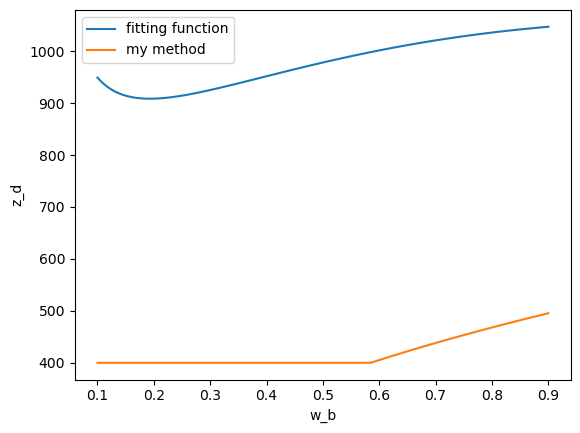

In [221]:
plt.plot(h, z_d_LCDM([0.264,Omg_b,0,Omg_r,0,0],100*h), label = "fitting function")
#plt.plot(Omg_b*h**2, z_d_arr1, label = "my method1")
plt.plot(h, z_d_arr, label = "my method")
#plt.plot(Omg_b*h**2, z_recomb_LCDM([0.264,Omg_b,0,Omg_r, 0,0],100*h), label = "z*")
plt.legend()
plt.xlabel("w_b")
plt.ylabel("z_d")

/tmp/ipykernel_768553/3022291161.py:27: RuntimeWarning: overflow encountered in exp
  return 1.747e-22*np.exp(157894/T)*T**1.5*Omega_b*(H0/100)**2


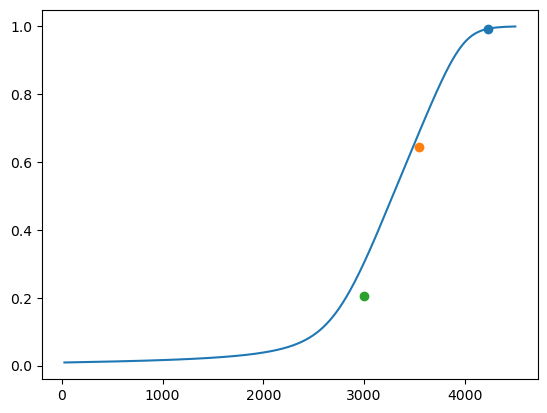

In [118]:
T_val = np.linspace(4500, 25, int(1e3))
h = 0.67
X_val = odeint(dXdT, X_BC([0.14/h**2,0.01/h**2,0,5.44e-5, 0,0], 4500, 100*h), T_val, args=([[0.14/h**2,0.01/h**2,0,5.44e-5, 0,0],h*100],), mxstep=int(1e4))
X_val = np.transpose(X_val)[0]
plt.plot(T_val, X_val)
plt.scatter(4226,0.992)
plt.scatter(3545,0.645)
plt.scatter(3000,0.205)

In [311]:
def log_likelihood_DV(theta, z, y, yerr):
    # note: c in km/s, H in km/s/Mpc and D_A in Mpc
    
    Omg_c, h, alpha_t = theta 
    Omg_b = 0.05 
    
    Omg_r = (2.47e-5*h**-2)*1.6917688896 # last factor due to neutrinos

    model = D_V_H0(z,[Omg_c , Omg_b , 0 , Omg_r , alpha_t,0])/r_d_H0([Omg_c , Omg_b , 0 , Omg_r , alpha_t,0],h)
    
    return -0.5 * np.matmul(np.matmul((y-model),np.linalg.inv(yerr)),np.transpose(y-model))

In [312]:
def log_likelihood_DM(theta, z, y, yerr):
    # note: c in km/s, H in km/s/Mpc and D_A in Mpc
    
    Omg_c, h, alpha_t = theta 
    Omg_b = 0.05 
    
    Omg_r = (2.47e-5*h**-2)*1.6917688896 # last factor due to neutrinos
    model = D_M_H0(z,[Omg_c, Omg_b , 0 , Omg_r , alpha_t,0])/r_d_H0([Omg_c, Omg_b , 0 , Omg_r , alpha_t,0],h)
    return -0.5 * np.matmul(np.matmul((y-model),np.linalg.inv(yerr)),np.transpose(y-model))

In [313]:
def log_likelihood_DH(theta, z, y, yerr):
    # note: c in km/s, H in km/s/Mpc and D_A in Mpc
    # note: log likelihood = -chi^2/2
    Omg_c, h, alpha_t = theta 
    Omg_b = 0.05 

    Omg_r = (2.47e-5*h**-2)*1.6917688896 # last factor due to neutrinos
    model = D_H_H0(z,[Omg_c, Omg_b , 0 , Omg_r , alpha_t,0])/r_d_H0([Omg_c, Omg_b , 0 , Omg_r , alpha_t,0],h)
    return -0.5 * np.matmul(np.matmul((y-model),np.linalg.inv(yerr)),np.transpose(y-model))

In [314]:
def log_prior(theta):
    Omg_c, h, alpha_t = theta 
    Omg_b = 0.05 

    if 0 < Omg_c + Omg_b < 1 and 0 < h < 1 and -1e-50 < alpha_t < 1 :
        return 0.0
    return -np.inf

In [315]:
def log_probability(theta, x, y, yerr):
    Omg_c, h, alpha_t = theta 
    lp = log_prior(theta)
    x_v, x_m, x_h = x
    y_v, y_m, y_h = y
    yerr_v, yerr_m, yerr_h = yerr
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_DV(theta, x_v, y_v, yerr_v) + log_likelihood_DM(theta, x_m, y_m, yerr_m)\
            + log_likelihood_DH(theta, x_h, y_h, yerr_h)

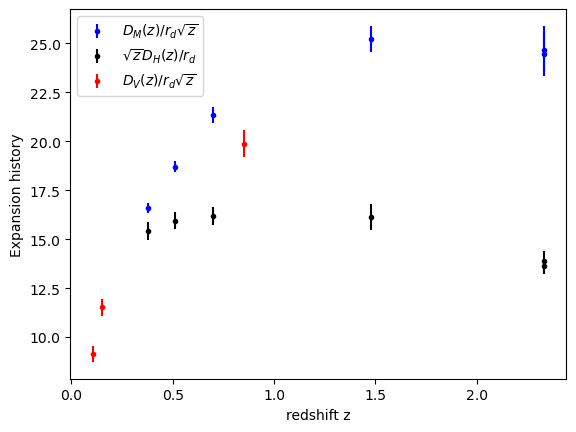

In [316]:
#get the data

# Choose the "true" parameters.
Omg_c_est = 0.3
h_est = 0.9
alpha_t_est = 1e-5

# BOSS Galaxy, eBOSS LRG, eBOSS Quasar =, Ly\alpha-Ly\alpha and Ly\alpha-Quasar data
x_D_mh_over_rd = np.array([0.38,0.51,0.70,1.48,2.33,2.33])

y_D_m_over_rd = np.array([10.23,13.36,17.86,30.69,37.6,37.3])
yerr_D_m_over_rd =np.diag([0.17,0.21,0.33,0.8,1.9,1.7])

y_D_h_over_rd = np.array([25,22.33,19.33,13.26,8.93,9.08])
yerr_D_h_over_rd =np.diag([0.76,0.58,0.53,0.55,0.28,0.34])

# eBOSS ELG data
x_ELG = 0.85
y_ELG_Dv_over_rd = 18.33
yerr_ELG_Dv_over_rd = 0.62 # TODO how do you account for different max/min?

# 6dFGS and MGS data
x_6dFGS = 0.106
y_6dFGS_Dv_over_rd = 1/0.336
yerr_6dFGS_Dv_over_rd = 0.015/0.336**2

rd_fid = 148.69
x_MGS = 0.15
y_MGS_Dv_over_rd = 664 / rd_fid
yerr_MGS_Dv_over_rd = 25 / rd_fid # TODO check

# Combine data
x = [np.array([x_ELG,x_6dFGS,x_MGS]),x_D_mh_over_rd,x_D_mh_over_rd]
y = [np.array([y_ELG_Dv_over_rd,y_6dFGS_Dv_over_rd,y_MGS_Dv_over_rd]),y_D_m_over_rd,y_D_h_over_rd]
sigma = [np.diag([yerr_ELG_Dv_over_rd**2,yerr_6dFGS_Dv_over_rd**2,yerr_MGS_Dv_over_rd**2]) , yerr_D_m_over_rd**2 , yerr_D_h_over_rd**2]

# Plot our data
plt.errorbar(x_D_mh_over_rd, y_D_m_over_rd/np.sqrt(x_D_mh_over_rd), yerr=np.diag(yerr_D_m_over_rd/np.sqrt(x_D_mh_over_rd)), fmt=".b", capsize=0, label = r"$D_M(z)/r_d\sqrt{z}$")
plt.errorbar(x_D_mh_over_rd, y_D_h_over_rd*np.sqrt(x_D_mh_over_rd), yerr=np.diag(yerr_D_h_over_rd)*np.sqrt(x_D_mh_over_rd), fmt=".k", capsize=0, label = r"$\sqrt{z}D_H(z)/r_d$")

plt.errorbar([x_6dFGS,x_MGS,x_ELG], [y_6dFGS_Dv_over_rd/np.sqrt(x_6dFGS), y_MGS_Dv_over_rd/np.sqrt(x_MGS), y_ELG_Dv_over_rd/np.sqrt(x_ELG)],\
             yerr=[yerr_6dFGS_Dv_over_rd/np.sqrt(x_6dFGS), yerr_MGS_Dv_over_rd/np.sqrt(x_MGS), yerr_ELG_Dv_over_rd/np.sqrt(x_ELG)], fmt=".r", capsize=0, label = r"$D_V(z)/r_d\sqrt{z}$")
plt.legend()
x0 = np.linspace(0, 10, 500)
plt.xlabel("redshift z")
plt.ylabel("Expansion history");

In [ ]:
#MCMC method

# initializing the walkers in a tiny Gaussian ball around the maximum likelihood result
#and then run 10,000 steps of MCMC
pos = [Omg_c_est , h_est, alpha_t_est] + 1e-4 * np.random.randn(50, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, sigma)
)
sampler.run_mcmc(pos, 500, progress=True);

/tmp/ipykernel_731561/2921289138.py:27: RuntimeWarning: overflow encountered in exp
  return 1.747e-22*np.exp(157894/T)*T**1.5*Omega_b*(H0/100)**2
/tmp/ipykernel_731561/2921289138.py:72: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  tau[i] = scipy.integrate.quad(lambda x: -np.interp(-x, -T_val, -n_p_T)*(1+x)/E(x,cosmo), 0.01 , z[i])[0]
/tmp/ipykernel_731561/2921289138.py:72: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tau[i] = scipy.integrate.quad(lambda x: -

In [ ]:
flat_samples = sampler.get_chain(discard=400, thin=15, flat=True)
labels = ["Omg_c", "h", "alpha_t"]
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=labels
);

In [ ]:
samples_chain = sampler.chain
print(len(samples_chain))
print(len(samples_chain[0]))
print(len(samples_chain[0][0]))
print(len(samples_chain[0, :, 0]))

fig, ax = plt.subplots(3)

for i in range(len(samples_chain)):
    ax[0].plot(samples_chain[i, :, 0], color = "black")
    ax[1].plot(samples_chain[i, :, 1], color = "black")
    ax[2].plot(samples_chain[i, :, 2], color = "black")


In [213]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.15f}_{{-{1:.15f}}}^{{{2:.15f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

NameError: name 'flat_samples' is not defined

In [ ]:
# --- PLOT DATA WITH ESTIMATED PARAMS -----

# data
plt.errorbar(x_D_mh_over_rd, y_D_m_over_rd/np.sqrt(x_D_mh_over_rd), yerr=np.diag(yerr_D_m_over_rd/np.sqrt(x_D_mh_over_rd)), fmt=".b", capsize=0, label = r"$D_M(z)/r_d\sqrt{z}$")
plt.errorbar(x_D_mh_over_rd, y_D_h_over_rd*np.sqrt(x_D_mh_over_rd), yerr=np.diag(yerr_D_h_over_rd)*np.sqrt(x_D_mh_over_rd), fmt=".k", capsize=0, label = r"$\sqrt{z}D_H(z)/r_d$")

plt.errorbar([x_6dFGS,x_MGS,x_ELG], [y_6dFGS_Dv_over_rd/np.sqrt(x_6dFGS), y_MGS_Dv_over_rd/np.sqrt(x_MGS), y_ELG_Dv_over_rd/np.sqrt(x_ELG)],\
             yerr=[yerr_6dFGS_Dv_over_rd/np.sqrt(x_6dFGS), yerr_MGS_Dv_over_rd/np.sqrt(x_MGS), yerr_ELG_Dv_over_rd/np.sqrt(x_ELG)], fmt=".r", capsize=0, label = r"$D_V(z)/r_d\sqrt{z}$")
plt.legend()
plt.xlabel("redshift z")
plt.ylabel("Expansion history");


xl = np.linspace(0.001,3,int(1e2))
for Omg_c, h, alpha_t in flat_samples[np.random.randint(len(flat_samples), size=100)]:
    Omg_r = (2.47e-5*h**-2)*1.6917688896
    plt.plot(xl, np.sqrt(xl)*D_H_H0(xl,[Omg_c , 0.05 , 0 , Omg_r , alpha_t , 0])/r_d_H0([Omg_c , 0.05 , 0 , Omg_r , alpha_t , 0],h), color="k", alpha=0.1)
    plt.plot(xl, D_V_H0(xl,[Omg_c , 0.05 , 0 , Omg_r , alpha_t , 0])/(r_d_H0([Omg_c , 0.05 , 0 , Omg_r , alpha_t , 0],h)*np.sqrt(xl)), color="r", alpha=0.1)
    plt.plot(xl, D_M_H0(xl,[Omg_c , 0.05 , 0 , Omg_r , alpha_t , 0])/(r_d_H0([Omg_c , 0.05 , 0 , Omg_r , alpha_t , 0],h)*np.sqrt(xl)), color="b", alpha=0.1)
